# How far will a player go in the EURO Championship based on his personal statistics?

I used a dataset with basic statistics of players participating in the Euro Championship to determine if it's possible to predict how a player will perform in this competition.

## Imports and loading the data

I began by importing the necessary libraries for my analysis.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

Then, I loaded the data of the players.

In [12]:
euro_data = pd.read_csv("euro2024_players.csv")
euro_data.head()

,Name,Position,Age,Club,Height,Foot,Caps,Goals,MarketValue,Country
0,Marc-André ter Stegen,Goalkeeper,32,FC Barcelona,187,right,40,0,28000000,Germany
1,Manuel Neuer,Goalkeeper,38,Bayern Munich,193,right,119,0,4000000,Germany
2,Oliver Baumann,Goalkeeper,34,TSG 1899 Hoffenheim,187,right,0,0,3000000,Germany
3,Nico Schlotterbeck,Centre-Back,24,Borussia Dortmund,191,left,12,0,40000000,Germany
4,Jonathan Tah,Centre-Back,28,Bayer 04 Leverkusen,195,right,25,0,30000000,Germany


And also the data of the countries.

In [13]:
euro_countries = pd.read_excel("euro_countries.xlsx")
euro_countries.head()

,COUNTRY,GROUP,GS_FINAL_STANDINGS,GS_QUALIFIED
0,Albania,B,4,0
1,Austria,D,1,1
2,Belgium,E,2,1
3,Croatia,B,3,0
4,Czech Republic,F,4,0


I joined my two datasets.

In [14]:
euro_full = pd.merge(euro_data, euro_countries, "left", left_on = "Country", right_on = "COUNTRY")
euro_full = euro_full.drop(columns = ["COUNTRY"])
euro_full.head()

,Name,Position,Age,Club,Height,Foot,Caps,Goals,MarketValue,Country,GROUP,GS_FINAL_STANDINGS,GS_QUALIFIED
0,Marc-André ter Stegen,Goalkeeper,32,FC Barcelona,187,right,40,0,28000000,Germany,A,1,1
1,Manuel Neuer,Goalkeeper,38,Bayern Munich,193,right,119,0,4000000,Germany,A,1,1
2,Oliver Baumann,Goalkeeper,34,TSG 1899 Hoffenheim,187,right,0,0,3000000,Germany,A,1,1
3,Nico Schlotterbeck,Centre-Back,24,Borussia Dortmund,191,left,12,0,40000000,Germany,A,1,1
4,Jonathan Tah,Centre-Back,28,Bayer 04 Leverkusen,195,right,25,0,30000000,Germany,A,1,1


## Exploratory Data Analysis

I started by examining the distribution of some variables in the dataset.

How many players are there in each position in the tournament?

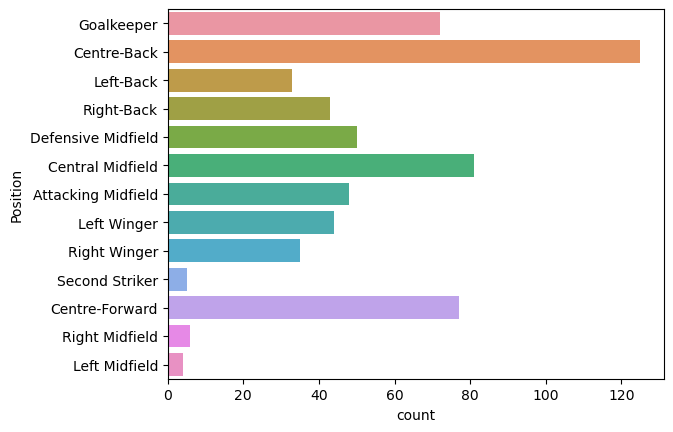

In [15]:
sns.countplot(data = euro_full, y = "Position")
plt.show()

How many players from each club are participating in the tournament?

In [16]:
euro_full.Club.value_counts()

Club
Manchester City          13
Inter Milan              13
FC Barcelona             12
Real Madrid              12
Paris Saint-Germain      12
                         ..
FC Südtirol               1
NK Olimpija Ljubljana     1
Barnsley FC               1
NK Celje                  1
Twente Enschede FC        1
Name: count, Length: 219, dtype: int64

How many appearances do the players have with their national teams?

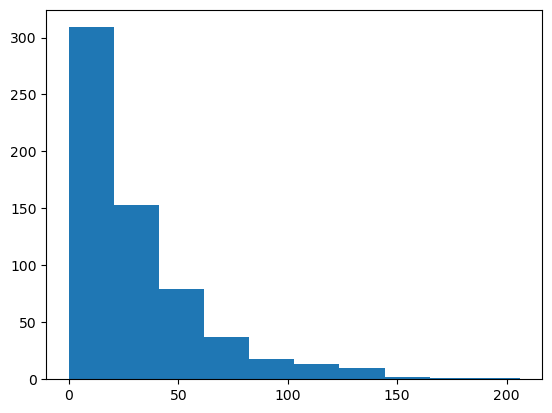

In [17]:
plt.hist(euro_full.Caps)
plt.show()

Let's take a closer look at the outliers.

In [18]:
euro_full[euro_full["Caps"] >= 150]

,Name,Position,Age,Club,Height,Foot,Caps,Goals,MarketValue,Country,GROUP,GS_FINAL_STANDINGS,GS_QUALIFIED
145,Luka Modric,Central Midfield,38,Real Madrid,172,right,174,24,6000000,Croatia,B,3,0
423,Jan Vertonghen,Centre-Back,37,RSC Anderlecht,189,left,154,10,1500000,Belgium,E,2,1
596,Cristiano Ronaldo,Centre-Forward,39,Al-Nassr FC,188,right,206,128,15000000,Portugal,F,1,1


Let's look at the height distribution of the players.

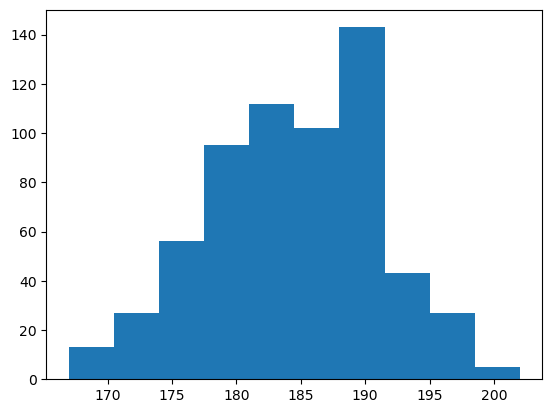

In [19]:
plt.hist(euro_full["Height"])
plt.show()

What is the dominant foot of the players?

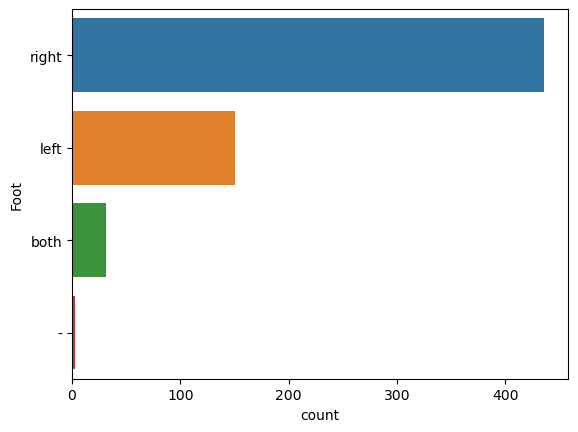

In [20]:
sns.countplot(data = euro_full, y = "Foot")
plt.show()

Let's look at the scored goals distribution of the players.

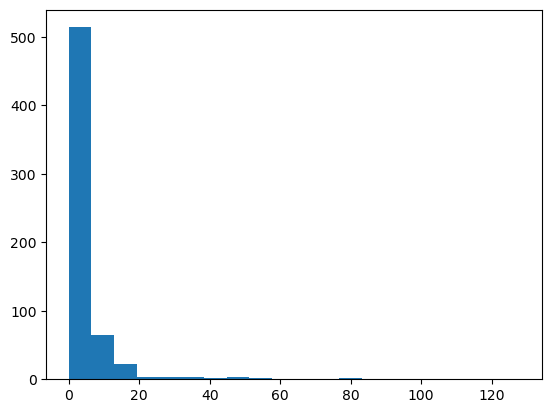

In [21]:
plt.hist(euro_full["Goals"], bins = 20)
plt.show()

A closer look at the outliers.

In [22]:
euro_full[euro_full["Goals"] >= 40]

,Name,Position,Age,Club,Height,Foot,Caps,Goals,MarketValue,Country,GROUP,GS_FINAL_STANDINGS,GS_QUALIFIED
22,Thomas Müller,Second Striker,34,Bayern Munich,185,right,129,45,8000000,Germany,A,1,1
257,Harry Kane,Centre-Forward,30,Bayern Munich,188,right,91,63,100000000,England,C,1,1
276,Christian Eriksen,Central Midfield,32,Manchester United,182,right,129,41,8000000,Denmark,C,2,1
309,Aleksandar Mitrovic,Centre-Forward,29,Al-Hilal SFC,189,right,90,57,28000000,Serbia,C,4,0
335,Robert Lewandowski,Centre-Forward,35,FC Barcelona,185,right,149,82,15000000,Poland,D,4,0
363,Memphis Depay,Centre-Forward,30,Atlético de Madrid,178,right,91,45,10000000,Netherlands,D,3,1
411,Kylian Mbappé,Centre-Forward,25,Paris Saint-Germain,178,right,78,47,180000000,France,D,2,1
414,Antoine Griezmann,Centre-Forward,33,Atlético de Madrid,176,left,128,44,25000000,France,D,2,1
415,Olivier Giroud,Centre-Forward,37,AC Milan,192,left,132,57,3000000,France,D,2,1
440,Romelu Lukaku,Centre-Forward,31,AS Roma,191,left,114,83,30000000,Belgium,E,2,1


How is the players market value distribution?

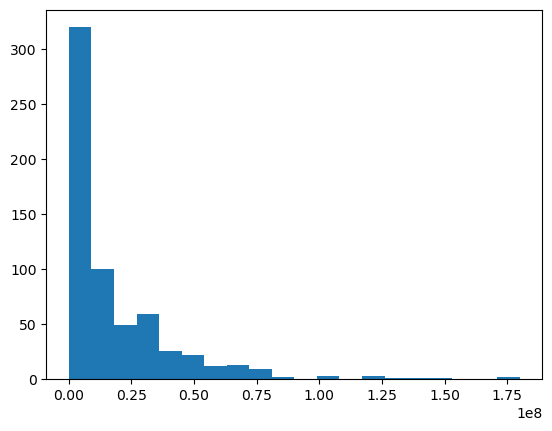

In [23]:
plt.hist(euro_full["MarketValue"], bins = 20)
plt.show()

Looking at the top outliers, we can see that all of them progressed past the group stage (GS_QUALIFIED).

In [24]:
euro_full[euro_full["MarketValue"] >= 100000000]

,Name,Position,Age,Club,Height,Foot,Caps,Goals,MarketValue,Country,GROUP,GS_FINAL_STANDINGS,GS_QUALIFIED
17,Florian Wirtz,Attacking Midfield,21,Bayer 04 Leverkusen,177,right,18,1,130000000,Germany,A,1,1
18,Jamal Musiala,Attacking Midfield,21,Bayern Munich,184,right,29,2,120000000,Germany,A,1,1
115,Rodri,Defensive Midfield,27,Manchester City,191,right,49,3,120000000,Spain,B,1,1
246,Declan Rice,Defensive Midfield,25,Arsenal FC,188,right,51,3,120000000,England,C,1,1
250,Jude Bellingham,Attacking Midfield,20,Real Madrid,186,right,29,3,180000000,England,C,1,1
254,Phil Foden,Right Winger,24,Manchester City,171,left,34,4,150000000,England,C,1,1
255,Bukayo Saka,Right Winger,22,Arsenal FC,178,left,33,11,140000000,England,C,1,1
257,Harry Kane,Centre-Forward,30,Bayern Munich,188,right,91,63,100000000,England,C,1,1
402,Aurélien Tchouaméni,Defensive Midfield,24,Real Madrid,188,right,31,3,100000000,France,D,2,1
404,Eduardo Camavinga,Central Midfield,21,Real Madrid,182,left,16,1,100000000,France,D,2,1


It appears that market value is the strongest predictor of whether a player will progress through the tournament.

## Build a classification model

Using player statistics, I have developed a classification model to predict whether a player will advance past the group stage.

Select the target (X) and predictor (y) variables.

In [25]:
X = euro_full.drop(columns = ["Name", "Country", "GROUP", "GS_FINAL_STANDINGS", "GS_QUALIFIED"])
y = euro_full["GS_QUALIFIED"]

I performed some preprocessing after modeling.

In [26]:
X.fillna({"Foot":"right"}, inplace = True)

In [27]:
cat_cols = ["Position", "Club", "Foot"]
num_cols = ["Age", "Height", "Caps", "Goals", "MarketValue"]

Splitted the data into training and test sets.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 19)

In [29]:
X_train_cat = X_train[cat_cols]
X_test_cat = X_test[cat_cols]
X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

Encoded the categorical variables.

In [30]:
ohe = OneHotEncoder(handle_unknown = "ignore")

In [31]:
X_train_cat_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.transform(X_test_cat)

In [32]:
X_train_cat_encoded = X_train_cat_encoded.toarray()
X_test_cat_encoded = X_test_cat_encoded.toarray()

In [33]:
X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns = ohe.get_feature_names_out())
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded, columns = ohe.get_feature_names_out())

In [34]:
X_train_num = X_train_num.reset_index(drop = True)
X_train_cat_encoded_df = X_train_cat_encoded_df.reset_index(drop = True)
X_test_num = X_test_num.reset_index(drop = True)
X_test_cat_encoded_df = X_test_cat_encoded_df.reset_index(drop = True)

In [35]:
X_train_preprocessed = pd.concat([X_train_num, X_train_cat_encoded_df], axis = 1)
X_test_preprocessed = pd.concat([X_test_num, X_test_cat_encoded_df], axis = 1)

I instantiated a model. In this case, I chose a Random Forest classifier, known for being a state-of-the-art ensemble method that has proven its versatility.

In [36]:
rf = RandomForestClassifier(random_state = 19)

I defined a parameter list and conducted a grid search to find the best hyperparameters for the Random Forest classifier.

In [37]:
param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [38]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

In [39]:
grid_search.fit(X_train_preprocessed, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=19), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [40]:
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Best parameters found: ", best_params)

Best parameters found:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


Next, using the best Random Forest classifier, I fitted my training data and obtained predictions for my test data.

In [41]:
best_rf.fit(X_train_preprocessed, y_train)

RandomForestClassifier(min_samples_split=10, random_state=19)

In [42]:
y_pred = best_rf.predict(X_test_preprocessed)
y_pred_prob = best_rf.predict_proba(X_test_preprocessed)

I plotted the classification report and confusion matrix to evaluate the model performance.

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.14      0.24        42
           1       0.69      0.96      0.80        83

    accuracy                           0.69       125
   macro avg       0.68      0.55      0.52       125
weighted avg       0.68      0.69      0.61       125



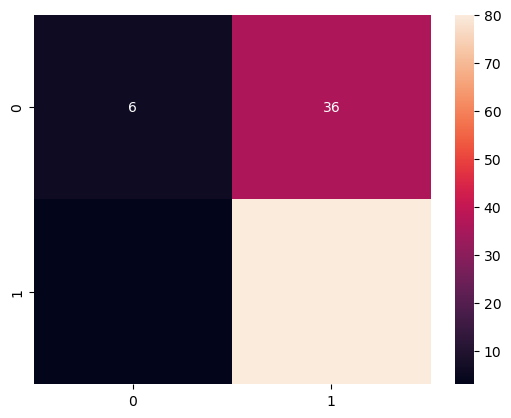

In [44]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.show()

I obtained the feature importance to determine which predictor variables are more influential in predicting whether a player will advance past the group stage.

In [45]:
importances = best_rf.feature_importances_
std = np.std([best_rf.feature_importances_ for rf in best_rf.estimators_], axis=0)
feature_names = X_train_preprocessed.columns

In [46]:
df = pd.DataFrame([importances, std], columns=feature_names)
df.index = ['Importances', 'Standard Deviations']

In [47]:
df_sorted = df.T.sort_values(by = "Importances", ascending = False)

The most influential variables are Market Value (as expected), along with Height, Appearances, Age, and Goals.

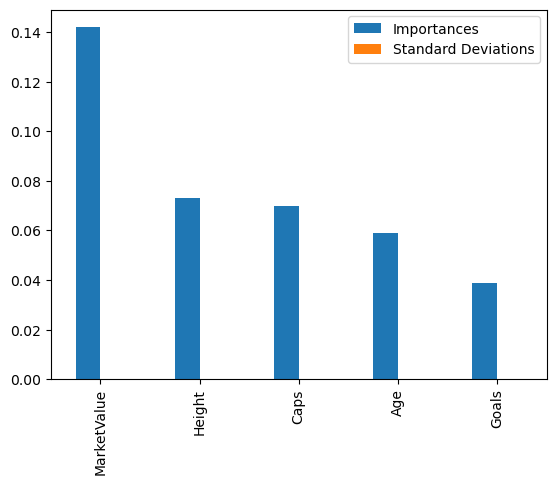

In [48]:
df_sorted.head().plot.bar()
plt.show()

## Compare the predictor variables for each target class

Players who advanced past the group stage have a higher market value.

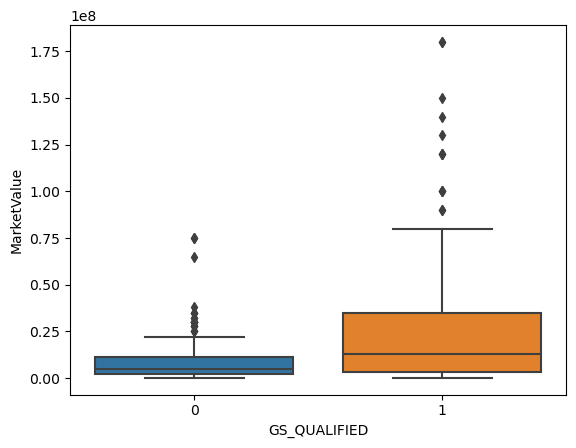

In [49]:
sns.boxplot(data = euro_full, y = "MarketValue", x = "GS_QUALIFIED")
plt.show()

There is practically no difference in this case. The height distribution of players who advanced is slightly narrower than those who did not, with an average of 1.85 meters in both cases.

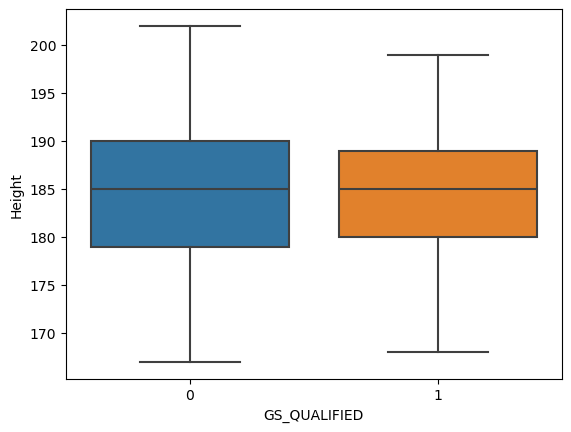

In [50]:
sns.boxplot(data = euro_full, y = "Height", x = "GS_QUALIFIED")
plt.show()

There is practically no difference in this case.

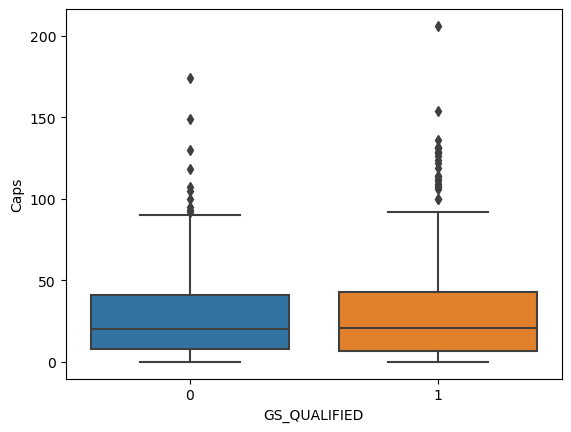

In [51]:
sns.boxplot(data = euro_full, y = "Caps", x = "GS_QUALIFIED")
plt.show()

There is practically no difference in this case.

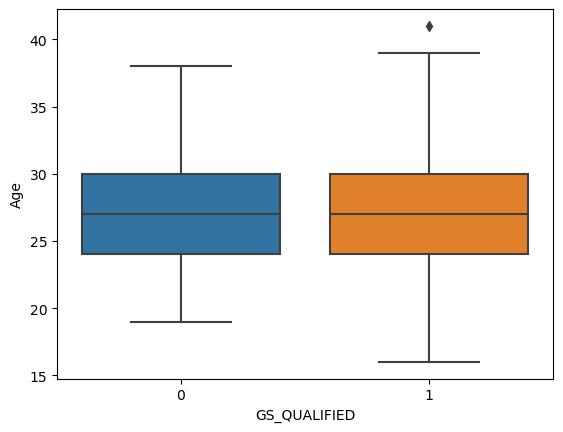

In [52]:
sns.boxplot(data = euro_full, y = "Age", x = "GS_QUALIFIED")
plt.show()

There is practically no difference in this case. Players who classified have slightly more goals than those who didn't.

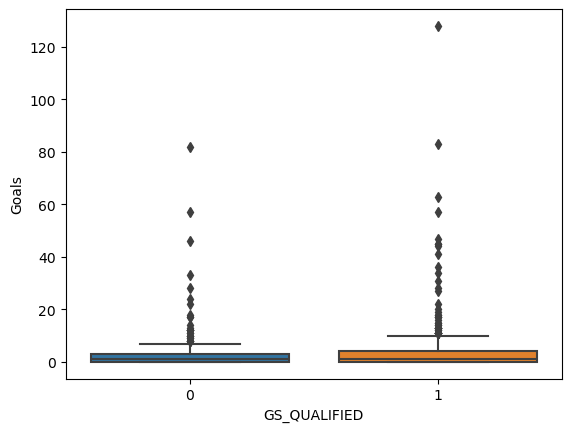

In [53]:
sns.boxplot(data = euro_full, y = "Goals", x = "GS_QUALIFIED")
plt.show()

## As soccer is a team sport, let's summarize the statistics by country.

In [54]:
country_stats = euro_full[["MarketValue", "Height", "Caps", "Age", "Goals", "Country"]].groupby(by = "Country").mean()

Here, we can see the average market value, height, appearences, age and goals, by country.

In [55]:
df_countries = pd.concat([euro_countries.set_index("COUNTRY"), country_stats], axis = 1)
df_countries

,GROUP,GS_FINAL_STANDINGS,GS_QUALIFIED,MarketValue,Height,Caps,Age,Goals
Albania,B,4,0,4.292308e+06,183.615385,26.115385,27.307692,1.538462
Austria,D,1,1,9.057692e+06,183.192308,23.576923,26.807692,3.576923
Belgium,E,2,1,2.338000e+07,184.680000,37.960000,26.880000,7.080000
Croatia,B,3,0,1.260385e+07,184.115385,44.307692,27.692308,5.653846
Czech Republic,F,4,0,7.457692e+06,185.538462,15.576923,25.307692,2.500000
Denmark,C,2,1,1.598077e+07,186.269231,41.192308,27.692308,5.192308
England,C,1,1,5.826923e+07,182.461538,25.038462,26.076923,3.846154
France,D,2,1,4.936000e+07,184.440000,33.440000,26.880000,7.680000
Georgia,F,3,1,6.159615e+06,184.500000,28.846154,27.153846,2.461538
Germany,A,1,1,3.273077e+07,185.384615,34.846154,28.115385,5.153846


And make the same comparison I did for the players.

The country average player market value is the most influential predictor.

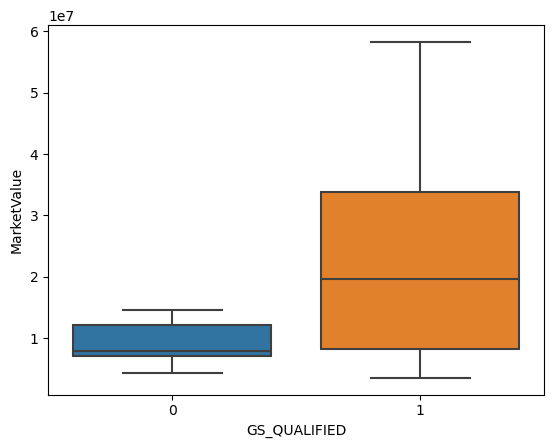

In [56]:
sns.boxplot(data = df_countries, y = "MarketValue", x = "GS_QUALIFIED")
plt.show()

The country average height didn't make any difference.

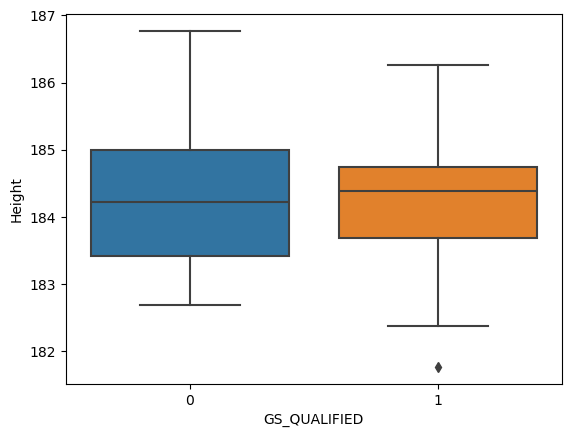

In [57]:
sns.boxplot(data = df_countries, y = "Height", x = "GS_QUALIFIED")
plt.show()

It looks like the countries that didn't classify didn't have a high average appearances.

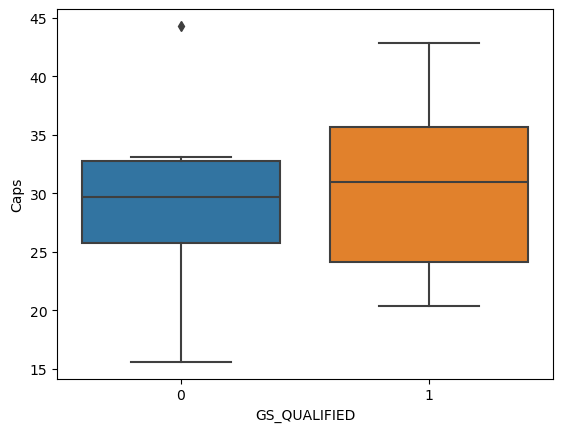

In [58]:
sns.boxplot(data = df_countries, y = "Caps", x = "GS_QUALIFIED")
plt.show()

The countries with a lower average age are more probable to classify.

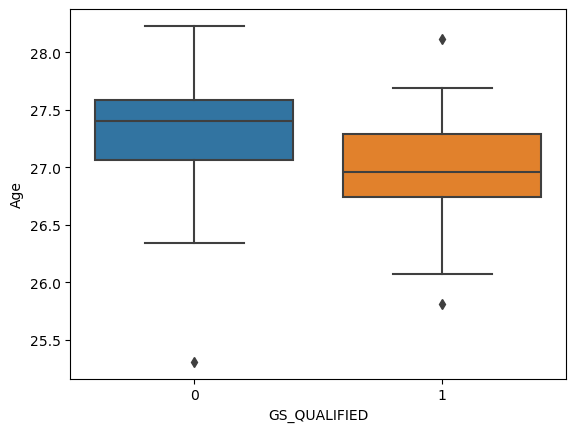

In [59]:
sns.boxplot(data = df_countries, y = "Age", x = "GS_QUALIFIED")
plt.show()

Finally, the country average player goals didn't make any difference.

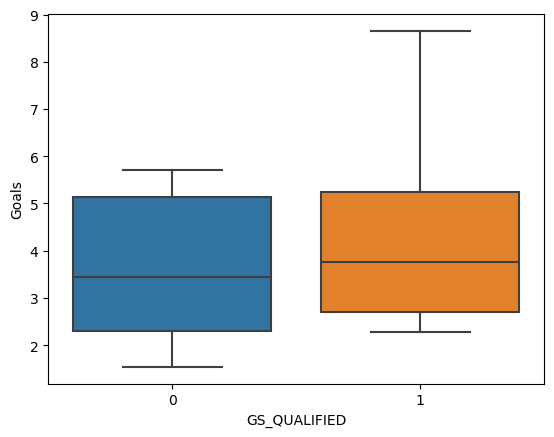

In [60]:
sns.boxplot(data = df_countries, y = "Goals", x = "GS_QUALIFIED")
plt.show()

## Among the countries that qualified, which ones have the lowest average market value?

Romania, Slovenia, Slovakia, and Georgia.

Will they manage to advance to the next stage?

In [61]:
df_gs_qualified = df_countries[df_countries.GS_QUALIFIED == 1].sort_values(by = "MarketValue", ascending = True)
df_gs_qualified

,GROUP,GS_FINAL_STANDINGS,GS_QUALIFIED,MarketValue,Height,Caps,Age,Goals
Romania,E,1,1,3.543269e+06,183.846154,22.692308,27.000000,2.423077
Slovenia,C,3,1,5.365385e+06,184.923077,29.653846,27.346154,3.000000
Slovakia,E,3,1,6.026923e+06,184.423077,33.153846,27.269231,2.576923
Georgia,F,3,1,6.159615e+06,184.500000,28.846154,27.153846,2.461538
Austria,D,1,1,9.057692e+06,183.192308,23.576923,26.807692,3.576923
Switzerland,A,2,1,1.084615e+07,183.923077,42.000000,27.692308,4.807692
Turkiye,F,2,1,1.246538e+07,183.923077,24.307692,25.807692,2.730769
Denmark,C,2,1,1.598077e+07,186.269231,41.192308,27.692308,5.192308
Belgium,E,2,1,2.338000e+07,184.680000,37.960000,26.880000,7.080000
Italy,B,2,1,2.713462e+07,184.346154,20.346154,26.500000,2.269231


As the Euro Championship is ongoing, I updated the results of the next two rounds...

In [62]:
QUALIFIED_16 = [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
QUALIFIED_4 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]

Unfortunately, none of the four low budget countries made it past the round of 16.

In [63]:
df_4_qualified = df_gs_qualified.copy()
df_4_qualified["QUALIFIED_16"] = QUALIFIED_16
df_4_qualified["QUALIFIED_4"] = QUALIFIED_4
df_4_qualified

,GROUP,GS_FINAL_STANDINGS,GS_QUALIFIED,MarketValue,Height,Caps,Age,Goals,QUALIFIED_16,QUALIFIED_4
Romania,E,1,1,3.543269e+06,183.846154,22.692308,27.000000,2.423077,0,0
Slovenia,C,3,1,5.365385e+06,184.923077,29.653846,27.346154,3.000000,0,0
Slovakia,E,3,1,6.026923e+06,184.423077,33.153846,27.269231,2.576923,0,0
Georgia,F,3,1,6.159615e+06,184.500000,28.846154,27.153846,2.461538,0,0
Austria,D,1,1,9.057692e+06,183.192308,23.576923,26.807692,3.576923,0,0
Switzerland,A,2,1,1.084615e+07,183.923077,42.000000,27.692308,4.807692,1,0
Turkiye,F,2,1,1.246538e+07,183.923077,24.307692,25.807692,2.730769,1,0
Denmark,C,2,1,1.598077e+07,186.269231,41.192308,27.692308,5.192308,0,0
Belgium,E,2,1,2.338000e+07,184.680000,37.960000,26.880000,7.080000,0,0
Italy,B,2,1,2.713462e+07,184.346154,20.346154,26.500000,2.269231,0,0


Among the 8 teams that advanced past the round of 16, 6 are among the top 6 most expensive. And our surprise teams are Turkey and Switzerland.

But, as expected, they didn't make it to the quarter finals.

The last four teams of the competition include the two most expensive teams. Portugal and Germany are not in the competition anymore, but this is because they played against France and England.

Now, the semi-finals are Spain-France and Netherlands-England. If we continue with the trend of all elimination rounds, France and England will play in the finals. And England will win the competition.

Perhaps soccer isn't so unpredictable after all.

## Final Conclusion

We started with the question of whether it was possible to predict if a player would advance past the group stage based on their statistics. We developed a model with 70% accuracy, with market value being the strongest predictor. We then analyzed by teams, confirming minimal surprises in this Euro Championship. If the tournament continues to be as predictable as it has been, England will be the winner.